In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
import arviz as az
import jax.random as jr
import matplotlib.pyplot as plt
from model import normal_normal_model
import numpy as np
from numpyro.infer import NUTS, MCMC
import pandas as pd
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

Here we draw from a simple model of a measurement.  There is some true parameter $x$ that is normally distributed with mean $\mu$ and s.d. $\sigma$.  We observe a parameter $x_\mathrm{obs}$ which is itself normally distributed about $x$ with (known) uncertainty $\sigma_\mathrm{obs}$, and we wish to infer $\mu$ and $\sigma$ from repeated observations.  The model is encoded in `normal_normal_model` from the `model.py` module.

To illustrate a common mistake in mock data, here we make the uncertainty $\sigma_\mathrm{obs}$ depend on the latent (and unknown) true parameter $x$; this introduces bias in our inferences, even though we treat $\sigma_\mathrm{obs}$ as known, because we don't account for it in our observational model (if the latent parameter $x$ is different, the uncertainty entering its terms in the MCMC should change as well, but this isn't reflected in our model).

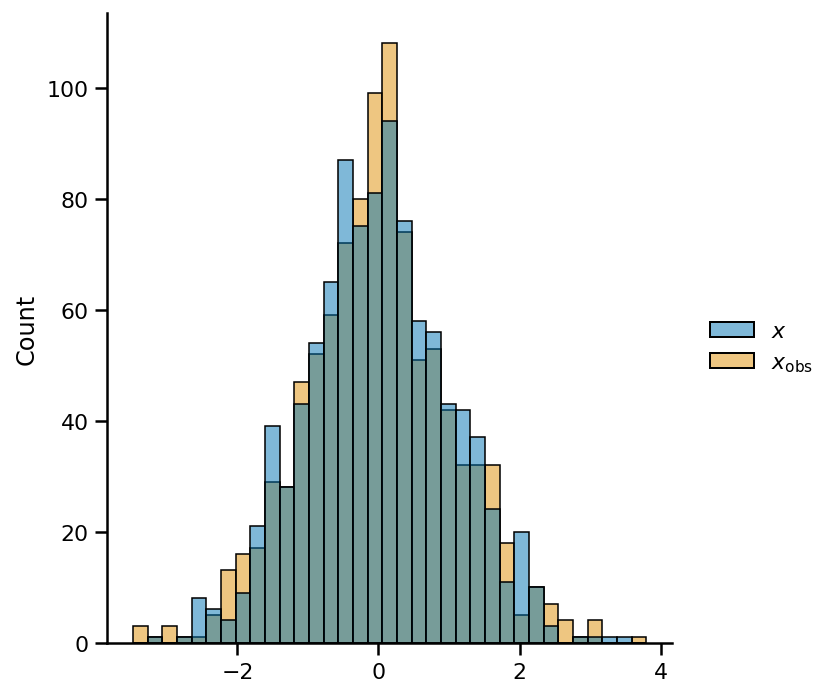

In [6]:
def sigma_of_x(x):
    return 0.1 + 0.2*np.abs(x)

N = 1000
mu_true = 0.0
sigma_true = 1.0

x_true = np.random.normal(loc=mu_true, scale=sigma_true, size=N)
sigma_obs = sigma_of_x(x_true)
x_obs = np.random.normal(loc=x_true, scale=sigma_obs)

df = pd.DataFrame({r'$x$':x_true, r'$x_\mathrm{obs}$':x_obs})
sns.displot(df)

In [12]:
kernel = NUTS(normal_normal_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(jr.PRNGKey(np.random.randint(1<<32)), x_obs, sigma_obs)
trace = az.from_numpyro(mcmc)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 311.62it/s, 3 steps of size 7.18e-01. acc. prob=0.95] 


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

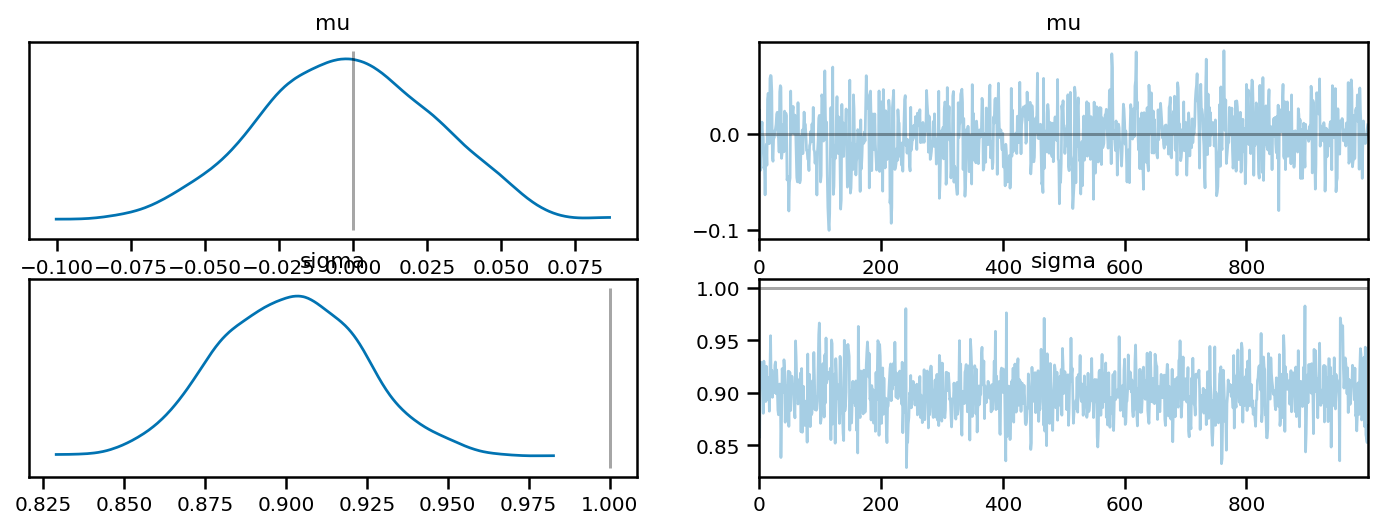

In [14]:
az.plot_trace(trace, lines=[('mu', {}, mu_true), ('sigma', {}, sigma_true)])

To fix the mistake, consider that the uncertainty comes randomly (we could also make the uncertainty depend on $x$ in the model; or we could make it depend on some other aspect of the data, say in a model where $x_\mathrm{obs} \sim \mathrm{Poisson}(x)$, and then the uncertainty is modeled with a Gaussian with width $\sqrt{x_\mathrm{obs}}$): then our model returns accurate inferences.

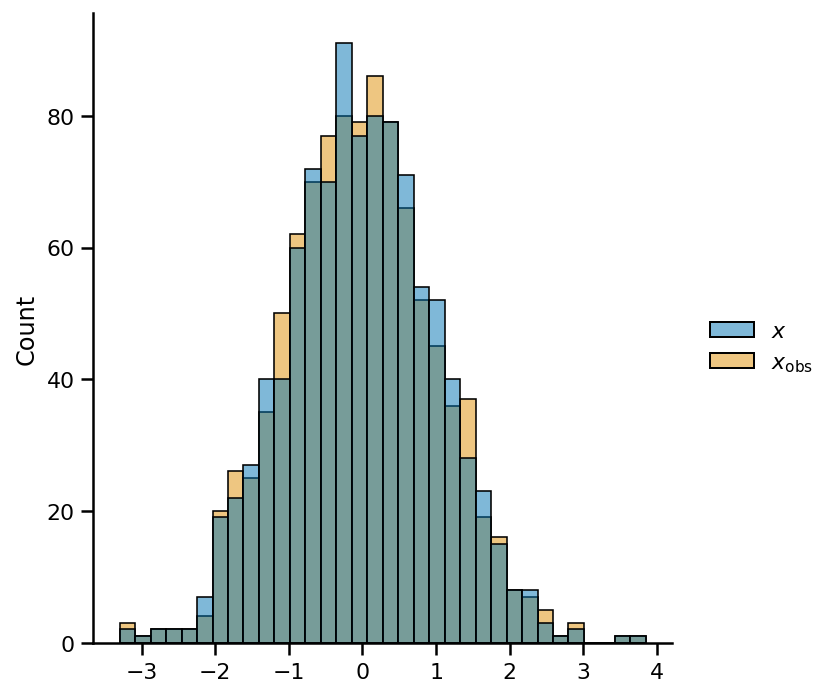

In [17]:
def sigma_of_x_random(x):
    return 0.1 + 0.2*np.random.uniform(low=0, high=1, size=x.shape[0])

N = 1000
mu_true = 0.0
sigma_true = 1.0

x_true_random = np.random.normal(loc=mu_true, scale=sigma_true, size=N)
sigma_obs_random = sigma_of_x_random(x_true)
x_obs_random = np.random.normal(loc=x_true, scale=sigma_obs)

df = pd.DataFrame({r'$x$':x_true, r'$x_\mathrm{obs}$':x_obs})
sns.displot(df)

In [18]:
kernel_random = NUTS(normal_normal_model)
mcmc_random = MCMC(kernel_random, num_warmup=1000, num_samples=1000)
mcmc_random.run(jr.PRNGKey(np.random.randint(1<<32)), x_obs_random, sigma_obs_random)
trace_random = az.from_numpyro(mcmc_random)

sample: 100%|██████████| 2000/2000 [00:08<00:00, 247.69it/s, 3 steps of size 8.72e-01. acc. prob=0.92] 


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

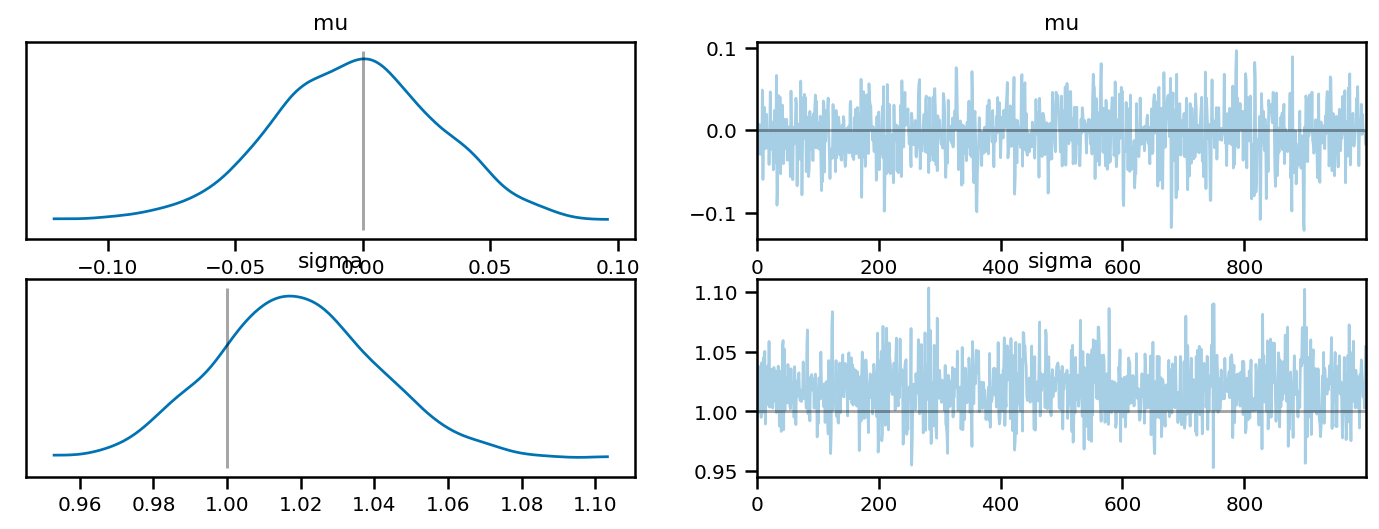

In [19]:
az.plot_trace(trace_random, lines=[('mu', {}, mu_true), ('sigma', {}, sigma_true)])